# Bayesian Relationship between the EUROSTOXX50 and ECB interest rates

This isn't supposed to be a rigourous exercise, it is more meant as a way to dip my toes back into the Pandas waters.

In [56]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
from pandas import Series, DataFrame
from dateutil.parser import parse
%matplotlib inline

First we'll define the start and end dates. The Euro Stoxx 50 started on 26/02/1998 so the start date will be set to then.

In [2]:
start = datetime.datetime(1998, 2, 26)
end = datetime.datetime(2020, 3, 1)

Now lets get the historical data for between these dates, and keep just the date and the close price (for simplicity):

In [3]:
df = web.DataReader('^STOXX50E', 'yahoo', start, end)
close = df[['Close']]
close.head()

,Close
Date,
1998-02-26,2875.610107
1998-02-27,2878.040039
1998-03-02,2929.020020
1998-03-03,2908.590088
1998-03-04,2878.590088


Next we need to get the historical interest rate changes from the ECB. To do this we'll get the table from the [ECB website](https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html).

In [4]:
tables = pd.read_html('https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html')
tables[0]

Date  \
                                   Unnamed: 0_level_1   
                                     With effect from   
0                                                2019   
1                                                2016   
2                                                2015   
3                                                2014   
4                                                 NaN   
5                                                2013   
6                                                 NaN   
7                                                2012   
8                                                2011   
9                                                 NaN   
10                                                NaN   
11                                                NaN   
12                                               2009   
13                                                NaN   
14                                                NaN   
15                                                NaN   
16                                               2008   
17                                                NaN   
18                                                NaN   
19                                                NaN   
20                                                NaN   
21                                                NaN   
22                                               2007   
23                                                NaN   
24                                               2006   
25                                                NaN   
26                                                NaN   
27                                                NaN   
28                                                NaN   
29                                               2005   
30                                               2003   
31                                                NaN   
32                                               2002   
33                                               2001   
34                                                NaN   
35                                                NaN   
36                                                NaN   
37                                               2000   
38                                                NaN   
39                                                NaN   
40                                                NaN   
41                                                NaN   
42                                                NaN   
43                                                NaN   
44                                               1999   
45                                                NaN   
46                                                NaN   
47                                                NaN   
48                                                NaN   
49  Prior to 10 March 2004, changes to the interes...   

                                                       \
                                   Unnamed: 1_level_1   
                                     With effect from   
0                                             18 Sep.   
1                                             16 Mar.   
2                                              9 Dec.   
3                                             10 Sep.   
4                                             11 Jun.   
5                                             13 Nov.   
6                                              8 May.   
7                                             11 Jul.   
8                                             14 Dec.   
9                                              9 Nov.   
10                                            13 Jul.   
11                                            13 Apr.   
12                                             13 May   
13                                             8 Apr.   
14                                            11 Mar.   
1

We get the right table with all the right data in, but the headings and data are messy. First the headings and columns need to be cleared up:

In [5]:
interest_rates = tables[0][['Date', 'Main refinancing operations']]
interest_rates.columns = ['Year','Month Day', 'Interest 1', 'Interest 2']
interest_rates.head()

,Year,Month Day,Interest 1,Interest 2
0,2019,18 Sep.,0.00,-
1,2016,16 Mar.,0.00,-
2,2015,9 Dec.,0.05,-
3,2014,10 Sep.,0.05,-
4,NaN,11 Jun.,0.15,-


I'm not sure why, but I was having issues using droplevel multiple times and recalculating the table so I reassigned the columns all in one operation. Now we need to clean up the data. Firstly the interest rate columns need to be merged, as well as useless rows removed.

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'
interest_rates['rate'] = interest_rates['Interest 1'] + interest_rates['Interest 2']
interest_rates = interest_rates.drop(columns=['Interest 1', 'Interest 2'])
interest_rates = interest_rates.drop([19, 20, 49])
interest_rates['rate'] = interest_rates['rate'].map(lambda x : float(str(x).strip('-')))
interest_rates.head()

,Year,Month Day,rate
0,2019,18 Sep.,0.00
1,2016,16 Mar.,0.00
2,2015,9 Dec.,0.05
3,2014,10 Sep.,0.05
4,NaN,11 Jun.,0.15


Now we need to sort out the date issues. This means we need to merge the date columns into one and then parse them.

In [7]:
interest_rates = interest_rates.fillna(method='ffill')
interest_rates['date'] = interest_rates['Year'] + ' ' + interest_rates['Month Day']
interest_rates['date'] = interest_rates['date'].map(
    lambda x: datetime.datetime.strptime(x.split('.')[0], '%Y %d %b')
)
interest_rates = interest_rates.drop(columns=['Year','Month Day'])
interest_rates = interest_rates.set_index('date')
interest_rates.head()

,rate
date,
2019-09-18,0.00
2016-03-16,0.00
2015-12-09,0.05
2014-09-10,0.05
2014-06-11,0.15


Since we're only taking MRO interest rates, we have duplicate  adjacent rows where another rate changed but the MRO rate stayed the same. In these cases we want to keep the last row, since the oldest change is where it actually changed.

In [8]:
a = interest_rates['rate']
interest_rates = a.loc[a.shift(-1) != a].to_frame()
interest_rates.head()

,rate
date,
2016-03-16,0.00
2014-09-10,0.05
2014-06-11,0.15
2013-11-13,0.25
2013-05-08,0.50


To calculate whether the EUROSTOXX50 index goes up or down depending on the interest rate change, we need to get the interest rate changes, not the interest rates themselves:

In [9]:
interest_rates['change'] = interest_rates.sort_index()['rate'].diff()
interest_rates.sort_index().head()

,rate,change
date,,
1999-01-01,3.00,NaN
1999-04-09,2.50,-0.50
1999-11-05,3.00,0.50
2000-02-04,3.25,0.25
2000-03-17,3.50,0.25


Let's see what the interest rates and the index look like on a simple line graph first:

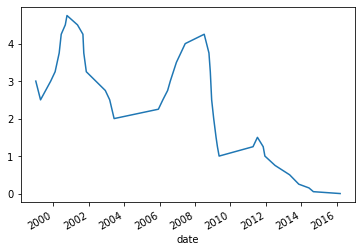

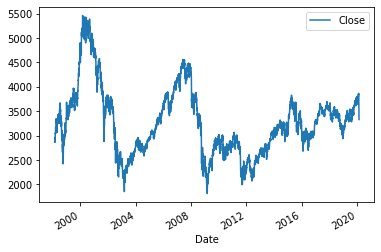

In [10]:
interest_rates['rate'].plot.line()
close.plot.line()

If we want to find the correlation between interest rate changes and stock market changes we need to get the stock market change values as well. We'll define the change as being the difference between the closing price the day before the interest rate changed and the closing price the day the interest rate changed. We just need these changes, not the changes for every day.

In [65]:
def get_dates(date_change, interval=1):
    before_date = date_change
    for i in range(interval, interval+10):
        new_date = date_change - datetime.timedelta(days=i)
        print(new_date)
        if new_date in close.index:
            before_date = new_date
            break
    for i in range(0, 10):
        if date_change + datetime.timedelta(days=i) in close.index:
            after_date = date_change + datetime.timedelta(days=i)
            break
    
    return (before_date, after_date)

In [67]:
get_dates(interest_rates.index[0])
#type(interest_rates.index[0])
#interest_rates.index
#pd.Timestamp('2016-03-15 00:00:00') in close.index

2016-03-15 00:00:00


(Timestamp('2016-03-15 00:00:00'), Timestamp('2016-03-16 00:00:00'))

SyntaxError: invalid syntax (<ipython-input-2-709069fe137d>, line 1)